In [1]:
from functools import partial
import math
import urllib
from pathlib import Path
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch
import tqdm
import torchvision
from torchvision import datasets, transforms

# Useful functions and Loading of the dataset

In [2]:
def load():
    """ Load training dataset and convert 'b' into 0 and 's' into 1
        Remove the 24th categorical feature
        Return the dataset and the removed feature """
   
    X_2 = np.genfromtxt("X_2.csv", delimiter=",")
    Y_2 = np.genfromtxt("Y_2.csv", delimiter=",")
    Fx_2 = np.genfromtxt("FX_2.csv", delimiter=",")
    Fy_2 = np.genfromtxt("FY_2.csv", delimiter=",")
    
    X_3 = np.genfromtxt("X_3.csv", delimiter=",")
    Y_3 = np.genfromtxt("Y_3.csv", delimiter=",")
    Fx_3 = np.genfromtxt("FX_3.csv", delimiter=",")
    Fy_3 = np.genfromtxt("FY_3.csv", delimiter=",")
    
    return X_2.T, Y_2.T, Fx_2.T, Fy_2.T, X_3.T, Y_3.T, Fx_3.T, Fy_3.T

###############################################################################

def distance_from_rotor(X, Y):
    R = 0.5
    r = np.sqrt(X**2 + Y**2)
    return R - r

###############################################################################

In [3]:
# loading data
X_2, Y_2, Fx_2, Fy_2, X_3, Y_3, Fx_3, Fy_3 = load()

N1 = X_2.shape[0]
N2 = X_3.shape[0]
D = X_2.shape[1]

# Useful functions for the creation of the dataset for FNNs

Functions:

- create_dataset_3feat_cnn
- create_dataset_3feat_cnn_onetraj
- merge_datasets_robustness
- random_permutation
- tensorize
- split_train_val

In [4]:
def create_dataset_3feat_cnn(N, D, dd, X, Y, dist, Fx, Fy):
    
    df_input = np.zeros((N*(D-dd), 3, dd))
    df_output = np.zeros((N*(D-dd), 2))
    i = 0

    for t in tqdm.tqdm(range(N)):
        
        for n in range(D-dd):

            for feat in range(3):

                row = np.zeros(dd)
                if (feat==0):
                    for d in range(dd):
                        row[d] = X[t,n+d]
              
                elif (feat==1):
                    for d in range(dd):
                        row[d] = Y[t,n+d]
                
                else: 
                    for d in range(dd):
                        row[d] = dist[t,n+d]

                df_input[i, feat, :] = row
          
            df_output[i, :] = np.array([Fx[t, n+dd], Fy[t, n+dd]])
         
            i = i+1
    
    return df_input, df_output

#########################################################################

def create_dataset_3feat_cnn_onetraj(D, dd, X, Y, dist, Fx, Fy):
    
    df_input = np.zeros(((D-dd), 3, dd))
    df_output = np.zeros(((D-dd), 2))
    i = 0

    for n in range(D-dd):
        
        for feat in range(3):
            
            row = np.zeros(dd)
            if (feat==0):
                for d in range(dd):
                    row[d] = X[n+d]
              
            elif (feat==1):
                for d in range(dd):
                    row[d] = Y[n+d]
            
            else: 
                for d in range(dd):
                    row[d] = dist[n+d]

            df_input[i, feat, :] = row
          
        df_output[i, :] = np.array([Fx[n+dd], Fy[n+dd]])
         
        i = i+1
    
    return df_input, df_output


In [5]:
def merge_datasets_robustness(df2, df3, n_train):
    #function to merge the 2 given datasets of trajectories varying pressure and rotor speed
    # df2.shape[0] = 450
    # df3.shape[0] == 1800
    # 9 sets of parameters
    
    n2 = int(df2.shape[0]/9) # == 50
    n3 = int(df3.shape[0]/9) # == 200
    NN = n2 + n3
    D = df2.shape[1] # == 2001 == df3.shape[1]
    
    df_train = np.zeros((n_train*9, D))
    df_test = np.zeros((((n2+n3)-n_train)*9, D))
    
    for i in range(9):
        df_train[i*n_train : (i+1)*n_train, :] = df3[n3*i : (n3*i+n_train), :]
        df_test[i*(NN-n_train):(i+1)*(NN-n_train), :]=np.r_[df3[(n3*i+n_train):(i+1)*n3, :], df2[i*n2:(i+1)*n2, :]]
     
    return df_train, df_test

In [6]:
n_train = 180
X, X_to_test = merge_datasets_robustness(X_2, X_3, n_train)
Y, Y_to_test = merge_datasets_robustness(Y_2, Y_3, n_train)
Fx, Fx_to_test = merge_datasets_robustness(Fx_2, Fx_3, n_train)
Fy, Fy_to_test = merge_datasets_robustness(Fy_2, Fy_3, n_train)

dist = distance_from_rotor(X, Y)
dist_to_test = distance_from_rotor(X_to_test, Y_to_test)

N = X.shape[0]
D = X.shape[1]

In [7]:
def random_permutation(df_input, df_output):

    N = df_input.shape[0]
    shuffle_indices = np.random.permutation(np.arange(N))
    df_in_shuff = df_input[shuffle_indices]
    df_out_shuff = df_output[shuffle_indices]

    return df_in_shuff, df_out_shuff


In [8]:
def tensorize(df_in_shuff, df_out_shuff):

    df_input_tensor = torch.Tensor(df_in_shuff)
    df_output_tensor = torch.Tensor(df_out_shuff)

    return df_input_tensor, df_output_tensor


In [9]:
def split_train_val(df_input_tensor, df_output_tensor, p):
  
    # Take the first p% of the dataset as training set and (1-p)% as validation set
    N = df_input_tensor.shape[0]
    df_in_train = df_input_tensor[:int(N*p), :]
    df_in_valid = df_input_tensor[int(N*p):, :]

    df_out_train = df_output_tensor[:int(N*p), :]
    df_out_valid = df_output_tensor[int(N*p):, :]

    return df_in_train, df_in_valid, df_out_train, df_out_valid


# Creation of the datasets

In [10]:
dd = 100
p = 0.9

df_input, df_output = create_dataset_3feat_cnn(N, D, dd, X, Y, dist, Fx, Fy)
df_in_shuff, df_out_shuff = random_permutation(df_input, df_output)
df_input_tensor, df_output_tensor = tensorize(df_in_shuff, df_out_shuff)
df_in_train, df_in_valid, df_out_train, df_out_valid = split_train_val(df_input_tensor, df_output_tensor, p)

train = torch.utils.data.TensorDataset(df_in_train, df_out_train)
test = torch.utils.data.TensorDataset(df_in_valid, df_out_valid) #VALIDATION

# Didn't change name not to change everything afterwords

100%|██████████████████████████████████████████████████████████████████████████████| 1620/1620 [03:47<00:00,  7.13it/s]


# Definition of the Feedforward Neural Network
Architecture: 
- 3 hidden fully connected layers ('hidden1', 'hidden2' and 'hidden3' neurons, respectively).
- Activation function: ReLu for each layer

In [11]:
class Aerospace_Bearing_CNN(torch.nn.Module):
    def __init__(self, d, feature_map1, feature_map2, feature_map3, kernel_size):
        super().__init__()
        self.__feature_map3 = feature_map3
        self.__d = d
        
        # CASE 1: convolution to the input and 3 convolutional layers --> skip + output --> Fully connected linear
        # Skip Connection
        self.skipconv = torch.nn.Conv1d(in_channels=3, out_channels=feature_map3, kernel_size=kernel_size, padding='same')

        # Convolution 1
        self.conv1 = torch.nn.Conv1d(in_channels=3, out_channels=feature_map1, kernel_size=kernel_size, padding='same')
        self.relu1 = torch.nn.ReLU()
        
        # Convolution 2
        self.conv2 = torch.nn.Conv1d(in_channels=feature_map1, out_channels=feature_map2, kernel_size=kernel_size, padding='same')
        self.relu2 = torch.nn.ReLU()
        
        # Convolution 3
        self.conv3 = torch.nn.Conv1d(in_channels=feature_map2, out_channels=feature_map3, kernel_size=kernel_size, padding='same')
        self.relu3 = torch.nn.ReLU()

        # Fully connected 1 (readout)
        self.fc1 = torch.nn.Linear(feature_map3*d, 2)
        
        # CASE 2: 4 convolutional layers --> skip + output --> Fully connected linear
        # Convolution 1
        # self.conv1 = torch.nn.Conv1d(in_channels=3, out_channels=feature_map1, kernel_size=kernel_size, padding='same')
        # self.relu1 = torch.nn.ReLU()
        
        # Convolution 2
        # self.conv2 = torch.nn.Conv1d(in_channels=feature_map1, out_channels=feature_map2, kernel_size=kernel_size, padding='same')
        # self.relu2 = torch.nn.ReLU()
        
        # Convolution 3
        # self.conv3 = torch.nn.Conv1d(in_channels=feature_map2, out_channels=feature_map3, kernel_size=kernel_size, padding='same')
        # self.relu3 = torch.nn.ReLU()
        
        # Convolution 4
        # self.conv4 = torch.nn.Conv1d(in_channels=feature_map3, out_channels=3, kernel_size=kernel_size, padding='same')
        # self.relu4 = torch.nn.ReLU()
        
        # Fully connected 1 (readout)
        # self.fc1 = torch.nn.Linear(3*d, 2)
        
    def forward(self, x):
        
        # CASE 1
        skip = self.skipconv(x)
        
        # Convolution 1
        out = self.conv1(x)
        out = self.relu1(out)

        # Convolution 2 
        out = self.conv2(out)
        out = self.relu2(out)
        
        # Convolution 3 
        out = self.conv3(out)
        out = self.relu3(out)
        
        # Skip connection
        out = out + skip
        
        out = out.view(-1, self.__d*self.__feature_map3)

        # Linear function (readout)
        out = self.fc1(out)
        
        # CASE 2
        # skip = x
        
        # Convolution 1
        # out = self.conv1(x)
        # out = self.relu1(out)

        # Convolution 2 
        # out = self.conv2(out)
        # out = self.relu2(out)
        
        # Convolution 3 
        # out = self.conv3(out)
        # out = self.relu3(out)
        
        # Convolution 4 
        # out = self.conv4(out)
        
        # Skip connection
        # out = out + skip
        # out = self.relu4(out)
        
        # out = out.view(-1, self.__d*3)

        # Linear function (readout)
        # out = self.fc1(out)

        return out


# Training process
- Optimizer: Adam's
- Scheduler: CosineAnnealingLR
- Criterion: MSE Loss Function

In [12]:
def train_epoch(model, optimizer, scheduler, criterion, train_loader, epoch, device):
    
    # Set model to training mode (affects dropout, batch norm e.g.)
    model.train()
    loss_history = []
    accuracy_history = []
    lr_history = []
    
    # Change the loop to get batch_idx, data and target from train_loader
    for batch_idx, (data, target) in enumerate(train_loader):
        
        # Move the data to the device
        data = data.to(device)
        target = target.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Compute model output
        output = model(data)
        
        # Compute loss
        loss = criterion(output, target)
        
        # Backpropagate loss
        loss.backward()
        
        # Perform an optimizer step
        optimizer.step()
        
        # Perform a learning rate scheduler step
        scheduler.step()

        # Compute loss_float (float value, not a tensor)
        loss_float = loss.item()

        # Add loss_float to loss_history
        loss_history.append(loss_float)

        lr_history.append(scheduler.get_last_lr()[0])
        if batch_idx % (len(train_loader.dataset) // len(data) // 10) == 0:
            print(
                f"Train Epoch: {epoch}-{batch_idx:03d} "
                f"batch_loss={loss_float:0.2e} "
                # f"batch_acc={accuracy_float:0.3f} "
                f"lr={scheduler.get_last_lr()[0]:0.3e} "
            )

    return loss_history, lr_history


@torch.no_grad()
def validate(model, device, val_loader, criterion):
    model.eval()  # Important: eval mode (affects dropout, batch norm etc)
    test_loss = 0
    
    for data, target in val_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        test_loss += criterion(output, target).item() * len(data)
        
    test_loss /= len(val_loader.dataset)

    print(
        "Test set: Average loss: {:.4f}".format(test_loss)
    )
    return test_loss


@torch.no_grad()
def get_predictions(model, device, val_loader, criterion, num=None):
    model.eval()
    points = []
    for data, target in val_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = criterion(output, target)
        
        data = np.split(data.cpu().numpy(), len(data))
        loss = np.split(loss.cpu().numpy(), len(data))
        target = np.split(target.cpu().numpy(), len(data))
        
        points.extend(zip(data, loss, target))

        if num is not None and len(points) > num:
            break

    return points


def run_aerobearing_cnn_training(ddd, feature_map1, feature_map2, feature_map3, ker, num_epochs, lr, batch_size, device="cuda"):
    # ===== Data Loading =====
    transform = transforms.ToTensor()
    train_set = train
    val_set = test

    train_loader = torch.utils.data.DataLoader(
        train_set,
        batch_size=batch_size,
        shuffle=False,  # Can be important for training
        pin_memory=torch.cuda.is_available(),
        drop_last=False,
        num_workers=2,
    )

    val_loader = torch.utils.data.DataLoader(
        val_set,
        batch_size=batch_size,
    )

    # ===== Model, Optimizer and Criterion =====
    # d = 100
    # feature_map1 = 16
    # feature_map2 = 16
    # kernel_size = 3
    # padding = 'same'

    model = Aerospace_Bearing_CNN(ddd, feature_map1, feature_map2, feature_map3, ker)
    model = model.to(device=device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    criterion = torch.nn.functional.mse_loss
    
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=(len(train_loader.dataset) * num_epochs) // train_loader.batch_size)
    
    # ===== Train Model =====
    lr_history = []
    train_loss_history = []
    val_loss_history = []
    
    for epoch in range(1, num_epochs + 1):
        train_loss, lrs = train_epoch(model, optimizer, scheduler, criterion, train_loader, epoch, device)
        train_loss_history.extend(train_loss)
        lr_history.extend(lrs)

        val_loss = validate(model, device, val_loader, criterion)
        val_loss_history.append(val_loss)
        
    # ===== Plot training curves =====
    n_train = len(train_loss_history)
    t_train = num_epochs * np.arange(n_train) / n_train
    t_val = np.arange(1, num_epochs + 1)

    plt.figure()
    plt.plot(t_train, train_loss_history, label="Train")
    plt.plot(t_val, val_loss_history, label="Val")
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    plt.figure()
    plt.plot(t_train, lr_history)
    plt.xlabel("Epoch")
    plt.ylabel("Learning Rate")

    return model

# Set-up of the parameters

The parameters which characterize the model are the following:
- The learning rate and the number of hidden layers which were obtained from the file `FNN_predicted_tuning` (respectively `lr`, `hidden1`, `hidden2`, `hidden3`)
- The size of the bacth and number of epochs (`batch_size`, `num_epochs`)

Train Epoch: 1-000 batch_loss=2.50e+00 lr=1.000e-02 
Train Epoch: 1-554 batch_loss=2.97e-02 lr=9.996e-03 
Train Epoch: 1-1108 batch_loss=2.58e-02 lr=9.985e-03 
Train Epoch: 1-1662 batch_loss=3.07e-02 lr=9.965e-03 
Train Epoch: 1-2216 batch_loss=3.29e-02 lr=9.938e-03 
Train Epoch: 1-2770 batch_loss=2.88e-02 lr=9.904e-03 
Train Epoch: 1-3324 batch_loss=2.54e-02 lr=9.862e-03 
Train Epoch: 1-3878 batch_loss=3.70e-02 lr=9.812e-03 
Train Epoch: 1-4432 batch_loss=2.27e-02 lr=9.755e-03 
Train Epoch: 1-4986 batch_loss=2.60e-02 lr=9.691e-03 
Train Epoch: 1-5540 batch_loss=2.51e-02 lr=9.620e-03 
Test set: Average loss: 0.0290
Train Epoch: 2-000 batch_loss=3.85e-02 lr=9.619e-03 
Train Epoch: 2-554 batch_loss=2.50e-02 lr=9.541e-03 
Train Epoch: 2-1108 batch_loss=2.34e-02 lr=9.455e-03 
Train Epoch: 2-1662 batch_loss=2.75e-02 lr=9.362e-03 
Train Epoch: 2-2216 batch_loss=2.94e-02 lr=9.263e-03 
Train Epoch: 2-2770 batch_loss=2.77e-02 lr=9.157e-03 
Train Epoch: 2-3324 batch_loss=2.13e-02 lr=9.045e-03 
T

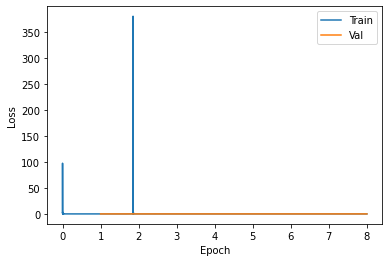

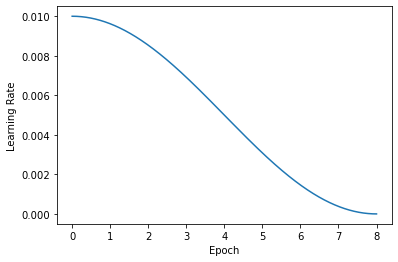

In [13]:
lr = 0.01
batch_size = 500
num_epochs = 8
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ddd = 100
feature_map1 = 64
feature_map2 = 32
feature_map3 = 64
ker = 3

model = run_aerobearing_cnn_training(ddd, feature_map1, feature_map2, feature_map3, ker, num_epochs, lr, batch_size, device)


# Testing the model

In [15]:
def get_MSE(df_in_test_tensor, df_out_test_tensor):
    
    losses = []
    losses_rel = []
    for i in tqdm.tqdm(range(len(df_in_test_tensor))):
        
        row = df_in_test_tensor[i, :, :]
        
        pred = model(row.to(device))
        pred = pred.to('cpu')
        
        # RMSE of the relative error
        loss = float(torch.mean((df_out_test_tensor[i, :] - pred)**2))
        loss_rel = float(torch.mean(torch.abs((df_out_test_tensor[i, :] - pred)/df_out_test_tensor[i, :])))
        losses.append(loss)
        losses_rel.append(loss_rel)
    
    losses = np.asarray(losses)
    losses_rel = np.asarray(losses_rel)
    mse = np.mean(losses)
    rel = np.mean(losses_rel)

    return mse, losses, rel, losses_rel

In [16]:
def get_RE(df_in_test_tensor, df_out_test_tensor):
    
    losses = []
    for i in tqdm.tqdm(range(len(df_in_test_tensor))):
        
        row = df_in_test_tensor[i, :, :]
        
        pred = model(row.to(device))
        pred = pred.to('cpu')
        
        # RMSE of the relative error
        loss = float(torch.mean((torch.abs(df_out_test_tensor[i, :] - pred)/df_out_test_tensor[i, :])))
        losses.append(loss)
    
    losses = np.asarray(losses)
    err_rel = np.mean(losses)

    return err_rel, losses

In [17]:
# create the dataset to test
nn = X_to_test.shape[0]
#dist_new = distance_from_rotor(X_new,Y_new)
df_in_test, df_out_test = create_dataset_3feat_cnn(nn, D, dd, X_to_test, Y_to_test, dist_to_test, Fx_to_test, Fy_to_test)
df_in_test_tensor, df_out_test_tensor = tensorize(df_in_test, df_out_test)

mse, losses, err_rel, losses_rel = get_MSE(df_in_test_tensor, df_out_test_tensor)
# err_rel, losses = get_RE(df_in_test_tensor, df_out_test_tensor)


100%|██████████████████████████████████████████████████████████████████████| 1197630/1197630 [11:23<00:00, 1751.77it/s]


In [ ]:
losses = np.asarray(losses)
losses_param = losses.reshape(9,-1)
print(mse)
print(len(losses))

##############################################################################
plt.figure(figsize=(25, 15))
for i in range(9):
    
    plt.plot(i+1,
             np.mean(losses_param[i]),
             marker="X",
             markersize=20,
             linestyle="None",
    #         color="blue",
    #         label="Predicted",
             linewidth=5,
            )
    
    plt.axhline(y = mse, color = 'k', linestyle = '--', linewidth=5)
    
plt.grid(True)
# plt.legend(fontsize=25)
plt.xlabel("Set of Parameters", fontsize=30)
plt.ylabel("Mean Loss", fontsize=30)

plt.tick_params(axis='x', labelsize=25)
plt.tick_params(axis='y', labelsize=25)
plt.savefig("CNN_robustness_mean_errors.png")

#########################################################################################
plt.figure(figsize=(25, 15))
for i in range(9):
    obs_per_param = len(losses_param[i])
    plt.plot(np.arange(i*obs_per_param, (i+1)*obs_per_param)/obs_per_param + 1,
             losses_param[i],
    #         marker="X",
    #         markersize=20,
    #         linestyle="None",
    #         color="blue",
    #         label="Predicted",
             linewidth=5,
            )
    
plt.grid(True)
# plt.legend(fontsize=25)
plt.xlabel("Observations per set of parameters", fontsize=30)
plt.ylabel("Error", fontsize=30)

plt.tick_params(axis='x', labelsize=25)
plt.tick_params(axis='y', labelsize=25)
plt.legend([fr'$r$= 150 Krpm, $p$= 200 KPa',fr'$r$= 150 Krpm, $p$= 250 KPa',fr'$r$= 150 Krpm, $p$= 300 KPa',fr'$r$= 200 Krpm, $p$= 200 KPa',fr'$r$= 200 Krpm, $p$= 250 KPa',fr'$r$= 200 Krpm, $p$= 300 KPa',fr'$r$= 250 Krpm, $p$= 200 KPa',fr'$r$= 250 Krpm, $p$= 250 KPa',fr'$r$= 250 Krpm, $p$= 300 KPa'])

#plt.savefig("CNN_robustness.png")


# Plot of a given trajectory of aerodynamic forces and its prediction


In [23]:
def plot_trajectory_coord_cnn(dd, traj):
    
    # save one trajectory to be plotted (tbp)
    tbp_X = X_to_test[traj,:]
    tbp_Y = Y_to_test[traj,:]
    tbp_Fx = Fx_to_test[traj,:]
    tbp_Fy = Fy_to_test[traj,:]
    tbp_d = dist_to_test[traj,:]
    
    traj_in, traj_out = create_dataset_3feat_cnn_onetraj(D, dd, tbp_X, tbp_Y, tbp_d, tbp_Fx, tbp_Fy)
    
    fx_pred_tbp = []
    fy_pred_tbp = []

    for i in range(len(traj_in)):
        row = torch.Tensor(traj_in[i,:,:])
        row = torch.unsqueeze(row,0)
        pred = model(row.to(device))
        fy_pred_tbp.append(float(pred[0][0]))
        fx_pred_tbp.append(float(pred[0][1]))

    plt.figure(figsize=(15, 15))
    
    plt.plot(fx_pred_tbp,
             fy_pred_tbp,
    #         marker="X",
    #         markersize=20,
    #         linestyle="None",
    #         color="blue",
             label="Predicted",
             linewidth=8,
            )

    plt.plot(traj_out[:,1],
             traj_out[:,0],
    #         marker="X",
    #         markersize=20,
    #         linestyle="None",
    #         color="blue",
             label="True",
             linewidth=8,
            )

    plt.grid(True)
    plt.legend(fontsize=25)
    plt.xlabel("F_x", fontsize=30)
    plt.ylabel("F_y", fontsize=30)

    plt.tick_params(axis='x', labelsize=25)
    plt.tick_params(axis='y', labelsize=25)


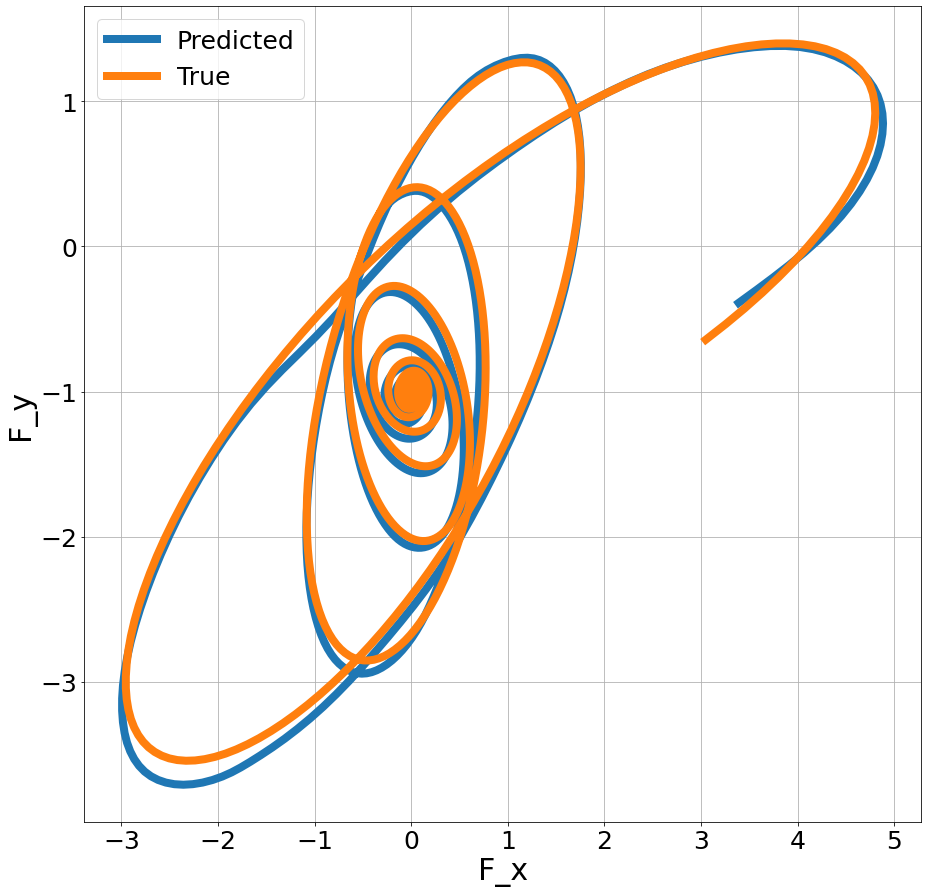

In [24]:
traj = 71
plot_trajectory_coord_cnn(dd, traj)

#plt.savefig("CNNrobustness.png")
